In [1]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Libreria para métricas
import scipy 
# Libreria para estimar regresión
import statsmodels.formula.api as sm
# Libreria para metricas 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Libreria para separar en train y test
from sklearn.model_selection import train_test_split
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)

In [2]:
# Levanto el dataset
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Variable Target: SalePrice
La variable objetivo es de tipo **numérica**, por lo que el modelo a desarrollar será de tipo **Aprendizaje Supervisado: Regresión**. 
<br> <br/>
A continuación se presentarán algunas estadísticas para entender el comportamiento, formato y distribución de esta variable. 

## Análisis Variable Target: SalePrice
Se puede observar que la variable tiene una distribución asimétrica positiva (la mediana es menor que el promedio), concentrando gran porción de los registros en valores bajos, y observando muy pocos registros en valores altos.  
<br> <br/>
Esto indicaría que hay muy pocas casas con precios extremadamente altos. 
<br> <br/>
Al tratar con una variable target de este tipo de distribución, una buena prácica suele ser intentar predecir el logaritmo de la variable, para suavizar un poco la curva de valores posibles. 
<br> <br/>
A continuación se presentará el histograma del logaritmo de la variable target. 

Text(0.5, 1.0, 'Distribución de SalePrice transformado a Logaritmo')

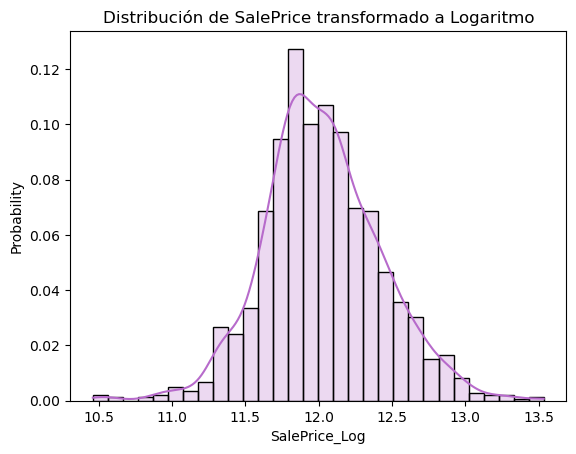

In [3]:
# Primero genero la variable logaritmica 
df['SalePrice_Log'] = np.log(df['SalePrice'])

# Luego grafico
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'SalePrice_Log',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB')
plt.title('Distribución de SalePrice transformado a Logaritmo')

# Comparemos modelos 

In [4]:
# Primero calculo variables de antiguedad
df['Antig_Viv'] = df['YrSold'] - df['YearBuilt']
df['Antig_Rem'] = np.where( df['YearRemodAdd'] > df['YrSold'],
                            df['YrSold'] - df['YearBuilt'],
                            df['YrSold'] - df['YearRemodAdd'])

# Renombro variable con nombre con numero
df = df.rename(columns={'1stFlrSF': 'Var_1stFlrSF'})

# MasVnrArea tiene vacíos, la completo con la mediana 
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

In [5]:
# Separo usando el paquete sklearn
df_train,df_test = train_test_split(df,
                                    test_size = 0.25, #Porcentaje de muestra test 
                                    random_state = 42) #Semilla

# Modelo 1: Con 11 Features

In [6]:
features_base = ['OverallQual','GarageCars','GrLivArea','Antig_Viv','GarageArea',
                 'Antig_Rem','FullBath','TotalBsmtSF','Var_1stFlrSF','TotRmsAbvGrd','MasVnrArea']
model_formula = 'SalePrice_Log ~ ' + ' + '.join(df_train[features_base].columns)
lm1 = sm.ols(formula = model_formula, data = df_train).fit()

coeficientes = lm1.params
print('Coeficientes:')
print(coeficientes.head(21).round(6))
print('')
print('-----------------------')
pvalores_1 = lm1.pvalues
print('P-Valores:')
print(pvalores_1.head(21).round(6).sort_values(ascending=False))

Coeficientes:
Intercept       10.924235
OverallQual      0.096310
GarageCars       0.087618
GrLivArea        0.000209
Antig_Viv       -0.001962
GarageArea       0.000044
Antig_Rem       -0.002169
FullBath        -0.026336
TotalBsmtSF      0.000063
Var_1stFlrSF     0.000060
TotRmsAbvGrd     0.007425
MasVnrArea      -0.000020
dtype: float64

-----------------------
P-Valores:
MasVnrArea      0.565000
GarageArea      0.419600
TotRmsAbvGrd    0.205586
FullBath        0.064886
Var_1stFlrSF    0.021819
TotalBsmtSF     0.005753
Intercept       0.000000
OverallQual     0.000000
GarageCars      0.000000
GrLivArea       0.000000
Antig_Viv       0.000000
Antig_Rem       0.000000
dtype: float64


In [7]:
# Genero columna de predicciones
df_train['Pred_1'] = lm1.predict(df_train)
df_test['Pred_1'] = lm1.predict(df_test)

# PLSR 

In [8]:
# Importo libreria
from sklearn.cross_decomposition import PLSRegression

features_base = ['OverallQual','GarageCars','GrLivArea','Antig_Viv','GarageArea',
                 'Antig_Rem','FullBath','TotalBsmtSF','Var_1stFlrSF','TotRmsAbvGrd','MasVnrArea']

X_train = df_train[features_base].values
X_test = df_test[features_base].values
y_train = df_train['SalePrice_Log'].values

# Crear un modelo PLSR con el número de componentes deseados
plsr_model = PLSRegression(n_components = 4)

# Ajustar el modelo PLSR a los datos de entrenamiento
plsr_model.fit(X_train, y_train)



PLSRegression(n_components=4)

In [10]:
# Predicciones 
df_train['Pred_2'] = plsr_model.predict(X_train)
df_test['Pred_2'] = plsr_model.predict(X_test)

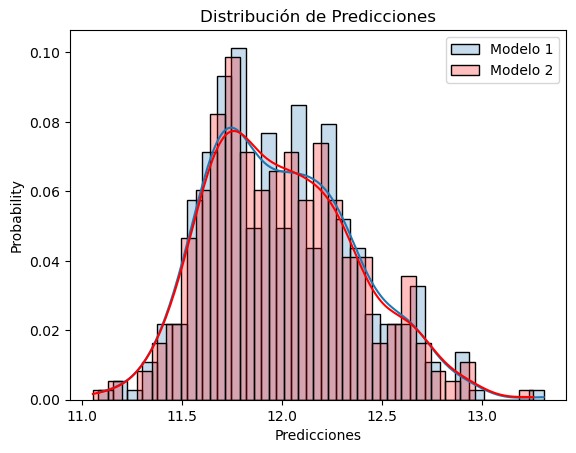

In [11]:
plt.figure()
# Histograma
sns.histplot(data = df_test,
             x = 'Pred_1',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            label = 'Modelo 1')
sns.histplot(data  = df_test, 
             x = 'Pred_2', 
             bins = 30, 
             alpha = 0.25, 
             kde = True, 
             stat='probability', 
             color='red', 
             label='Modelo 2')
plt.title('Distribución de Predicciones')
plt.xlabel('Predicciones')
plt.legend()
plt.show()

In [12]:
# Metricas
rmse_1_test= mean_squared_error(df_test['SalePrice_Log'], df_test['Pred_1'], squared=False)
r_squared_1_test = r2_score(df_test['SalePrice_Log'], df_test['Pred_1'])
rmse_1_train = mean_squared_error(df_train['SalePrice_Log'], df_train['Pred_1'], squared=False)
r_squared_1_train = r2_score(df_train['SalePrice_Log'], df_train['Pred_1'])

rmse_2_test = mean_squared_error(df_test['SalePrice_Log'], df_test['Pred_2'], squared=False)
r_squared_2_test = r2_score(df_test['SalePrice_Log'], df_test['Pred_2'])
rmse_2_train = mean_squared_error(df_train['SalePrice_Log'], df_train['Pred_2'], squared=False)
r_squared_2_train = r2_score(df_train['SalePrice_Log'], df_train['Pred_2'])

print('RMSE')
print('MODELO 1')
print('TEST: ' + str(rmse_1_test.round(4)))
print('TRAIN: ' + str(rmse_1_train.round(4)))
print('----------------')
print('MODELO 2')
print('TEST: ' + str(rmse_2_test.round(4)))
print('TRAIN: ' + str(rmse_2_train.round(4)))

RMSE
MODELO 1
TEST: 0.1646
TRAIN: 0.1713
----------------
MODELO 2
TEST: 0.1649
TRAIN: 0.1719


# Clustering

# K - Means
## Identificar cantidad de clusters óptima
Utilizaremos la métrica 'inertia_', que se utiliza para evaluar la calidad de la agrupación resultante. 
<br>

Mide cuánto están dispersos los puntos dentro de cada clúster. En otras palabras, cuantifica la variabilidad total dentro de los clústeres.
<br>

Se busca un punto en el que la inertia disminuye significativamente a medida que se aumenta el número de clústeres (k) y luego se estabiliza. Este punto se conoce como el "codo" en el gráfico de la inertia frente al número de clústeres. El número de clústeres correspondiente a este codo se considera un buen candidato para el número óptimo de clústeres. 
<br>

In [16]:
features_base = ['OverallQual','GarageCars','GrLivArea','Antig_Viv','GarageArea']

medias = df_train[features_base].mean()
desvios = df_train[features_base].std()

df_train_normalizada = (df_train[features_base] - medias) / desvios
df_test_normalizada = (df_test[features_base] - medias) / desvios

X_train_norm = df_train_normalizada.values
X_test_norm = df_test_normalizada.values


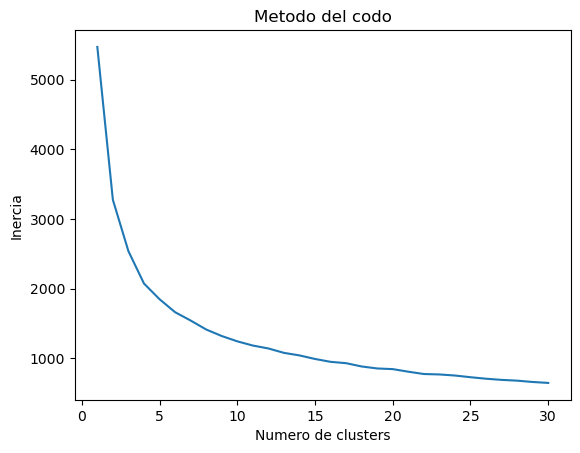

In [17]:
# Libreria para KMeans
from sklearn.cluster import KMeans
# Genero distintos algoritmos para definir el n_cluster que más me convence
wcss = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train_norm)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 31), wcss)
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.show()

In [32]:
# Genero el modelo
n_clusters = 7
kmeans = KMeans(n_clusters = n_clusters, 
                init = 'k-means++', 
                max_iter = 300, 
                n_init = 10, 
                random_state = 0)

In [33]:
# Construyo dataframe con predicciones 
df_analizar_pred = pd.DataFrame(X_train_norm)
df_analizar_pred['Cluster'] = kmeans.fit_predict(X_train_norm)
df_analizar_pred.head()

,0,1,2,3,4,Cluster
0,0.636782,0.293696,-0.051620,-1.100502,-0.192529,5
1,-0.094883,0.293696,-0.421500,-0.153777,0.030681,2
2,-0.094883,-1.069005,-0.518237,1.086758,-0.938147,4
3,-0.826548,-1.069005,-0.207159,0.335908,-0.909652,1
4,-0.094883,-1.069005,-0.169222,0.401199,-0.838415,1


In [34]:
df_analizar_pred['Cluster'].value_counts().sort_index()

0    135
1    184
2    220
3    101
4     81
5    319
6     55
Name: Cluster, dtype: int64

In [35]:
# Agrego target
df_train_normalizada = df_train_normalizada.reset_index()
df_train = df_train.reset_index()
df_analizar_pred['SalePrice_Log'] = df_train['SalePrice_Log']

Text(0.5, 1.0, 'Relación entre Logaritmo del Precio de Venta y Cluster')

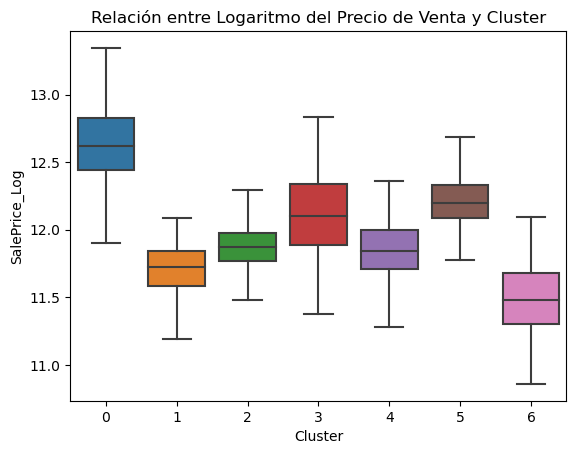

In [36]:
# Boxplot
plt.figure()
sns.boxplot(data = df_analizar_pred,
            x = 'Cluster',
            y = 'SalePrice_Log', 
            showfliers = False)
plt.title('Relación entre Logaritmo del Precio de Venta y Cluster')

In [37]:
# Analicemos el contenido de cada cluster
df_train['Cluster'] = df_analizar_pred['Cluster']
resultados = df_train.groupby('Cluster').agg(           
    Promedio_OverallQual = ('OverallQual', 'mean'),
    Promedio_GarageCars = ('GarageCars', 'mean'),
    Promedio_GrLivArea = ('GrLivArea', 'mean'),
    Promedio_Antig_Viv = ('Antig_Viv', 'mean'),
    Promedio_GarageArea = ('GarageArea', 'mean'),
    Mediana_SalePrice = ('SalePrice_Log', 'median')
).reset_index()
resultados

,Cluster,Promedio_OverallQual,Promedio_GarageCars,Promedio_GrLivArea,Promedio_Antig_Viv,Promedio_GarageArea,Mediana_SalePrice
0,0,8.177778,2.911111,2189.851852,6.392593,810.940741,12.623061
1,1,4.983696,1.000000,1093.048913,53.217391,299.869565,11.726017
2,2,5.213636,2.004545,1179.563636,43.559091,530.786364,11.870600
3,3,5.910891,2.079208,2072.920792,65.435644,541.564356,12.103486
4,4,5.987654,1.024691,1662.308642,82.407407,278.703704,11.842229
5,5,6.937304,2.015674,1621.018809,10.244514,514.755486,12.198544
6,6,4.527273,0.000000,1078.309091,61.963636,0.000000,11.482466


In [39]:
# Joineo con dataset original 
df_train = df_train.merge(resultados[['Cluster','Mediana_SalePrice']],
              left_on = 'Cluster',
              right_on = 'Cluster',
              how = 'left')


In [25]:
# Hago predicción de cluster en muestra de test
df_analizar_pred_test = pd.DataFrame(X_test_norm)
df_analizar_pred_test['Cluster'] = kmeans.fit_predict(X_test_norm)
df_test = df_test.reset_index()
df_test['Cluster'] = df_analizar_pred_test['Cluster']

In [40]:
# Joineo con dataset original 
df_test = df_test.merge(resultados[['Cluster','Mediana_SalePrice']],
              left_on = 'Cluster',
              right_on = 'Cluster',
              how = 'left')


In [38]:
columnas_a_eliminar = ['Mediana_SalePrice', 'Pred_3']
df_test.drop(columnas_a_eliminar, axis=1, inplace=True)
df_train.drop(columnas_a_eliminar, axis=1, inplace=True)

In [ ]:
df_test.head()

# Modelo 3 - Con Cluster

In [41]:
features_base = ['Mediana_SalePrice','Antig_Rem','FullBath','TotalBsmtSF','Var_1stFlrSF','TotRmsAbvGrd','MasVnrArea']
model_formula = 'SalePrice_Log ~ ' + ' + '.join(df_train[features_base].columns)
lm2 = sm.ols(formula = model_formula, data = df_train).fit()

coeficientes = lm2.params
print('Coeficientes:')
print(coeficientes.head(21).round(6))
print('')
print('-----------------------')
pvalores_1 = lm2.pvalues
print('P-Valores:')
print(pvalores_1.head(21).round(6).sort_values(ascending=False))

Coeficientes:
Intercept            4.128356
Mediana_SalePrice    0.620363
Antig_Rem           -0.003705
FullBath             0.008625
TotalBsmtSF          0.000149
Var_1stFlrSF         0.000074
TotRmsAbvGrd         0.038109
MasVnrArea           0.000127
dtype: float64

-----------------------
P-Valores:
FullBath             0.579633
Var_1stFlrSF         0.009910
MasVnrArea           0.001289
Intercept            0.000000
Mediana_SalePrice    0.000000
Antig_Rem            0.000000
TotalBsmtSF          0.000000
TotRmsAbvGrd         0.000000
dtype: float64


In [28]:
# Genero columna de predicciones
df_train['Pred_3'] = lm2.predict(df_train)
df_test['Pred_3'] = lm2.predict(df_test)

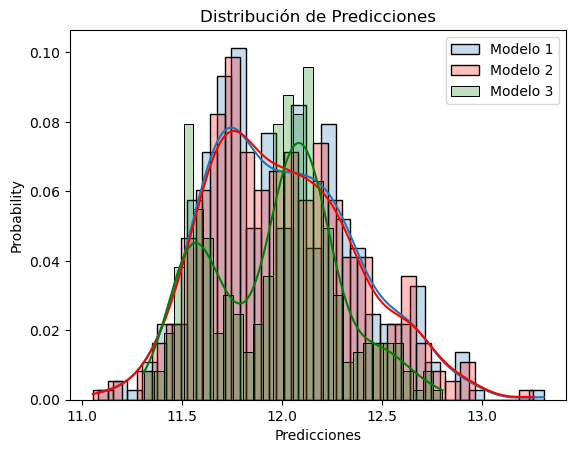

In [29]:
plt.figure()
# Histograma
sns.histplot(data = df_test,
             x = 'Pred_1',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            label = 'Modelo 1')
sns.histplot(data  = df_test, 
             x = 'Pred_2', 
             bins = 30, 
             alpha = 0.25, 
             kde = True, 
             stat='probability', 
             color='red', 
             label='Modelo 2')
sns.histplot(data  = df_test, 
             x = 'Pred_3', 
             bins = 30, 
             alpha = 0.25, 
             kde = True, 
             stat='probability', 
             color='green', 
             label='Modelo 3')
plt.title('Distribución de Predicciones')
plt.xlabel('Predicciones')
plt.legend()
plt.show()

In [30]:
# Metricas
rmse_3_test = mean_squared_error(df_test['SalePrice_Log'], df_test['Pred_3'], squared=False)
r_squared_3_test = r2_score(df_test['SalePrice_Log'], df_test['Pred_3'])
rmse_3_train = mean_squared_error(df_train['SalePrice_Log'], df_train['Pred_3'], squared=False)
r_squared_3_train = r2_score(df_train['SalePrice_Log'], df_train['Pred_3'])

print('RMSE')
print('MODELO 1')
print('TEST: ' + str(rmse_1_test.round(4)))
print('TRAIN: ' + str(rmse_1_train.round(4)))
print('----------------')
print('MODELO 2')
print('TEST: ' + str(rmse_2_test.round(4)))
print('TRAIN: ' + str(rmse_2_train.round(4)))
print('----------------')
print('MODELO 3')
print('TEST: ' + str(rmse_3_test.round(4)))
print('TRAIN: ' + str(rmse_3_train.round(4)))

RMSE
MODELO 1
TEST: 0.1646
TRAIN: 0.1713
----------------
MODELO 2
TEST: 0.1649
TRAIN: 0.1719
----------------
MODELO 3
TEST: 0.2845
TRAIN: 0.1988


In [31]:
print('r - 2')
print('MODELO 1')
print('TEST: ' + str(r_squared_1_test.round(4)))
print('TRAIN: ' + str(r_squared_1_train.round(4)))
print('----------------')
print('MODELO 2')
print('TEST: ' + str(r_squared_2_test.round(4)))
print('TRAIN: ' + str(r_squared_2_train.round(4)))
print('----------------')
print('MODELO 3')
print('TEST: ' + str(r_squared_3_test.round(4)))
print('TRAIN: ' + str(r_squared_3_train.round(4)))

r - 2
MODELO 1
TEST: 0.8435
TRAIN: 0.8102
----------------
MODELO 2
TEST: 0.8431
TRAIN: 0.809
----------------
MODELO 3
TEST: 0.5325
TRAIN: 0.7446
